**Oreum Industries Internal Project, 2024Q1**

---

# 001_MRE_ModelA0.ipynb

### Oreum Copula Demo in `oreum_copula`

Implementation of Bayesian Copula-Based Expected Loss Cost Forecasting. 
We use highly advanced Bayesian inference techniques and a Bayesian workflow, 
specifically using the `pymc` & `arviz` ecosystem.

Here we demonstrate an E2E workflow for novel models of increasing sophistication.
We evaluate the behaviour and performance of the models throughout the workflows,
including several state-of-the-art methods unavailable to conventional
max-likelihood / machine-learning models.

**In this Notebook:**

+ Build & evaluate `ModelA0`, a naive version of the core project architecture **without a copula**
+ Demonstrate some of the core aspects and make the case for needing a copula


## Contents

+ [Setup](#Setup)

+ [0. Synthesize Dataset](#0.-Synthesize-Dataset)

+ [1. Model Description](#1.-Model-Description)

+ [2. Custom Bayesian Model `ModelA0`](#2.-Custom-Bayesian-Model-`ModelA0`)

---

# Setup

## Imports

In [1]:
import sys
from copy import deepcopy
from pathlib import Path

import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Markdown, display
from oreum_core import eda
from oreum_core import model_pymc as mt
from pyprojroot.here import here

# prepend local project src files
module_path = here('src').resolve(strict=True)
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))    # sys.path.append(str(module_path))

# autoreload local modules to allow local dev
%load_ext autoreload
%autoreload 2
from engine import logger, utils  #.trainer import Trainer
from model import copula
from synthetic.create_copula import CopulaBuilder

import warnings  # isort:skip # suppress seaborn, it's far too chatty

warnings.simplefilter(action='ignore', category=FutureWarning)  # isort:skip

/Users/jon/miniforge/envs/oreum_copula/lib/python3.11/site-packages/pymc/util.py:38: FutureWarning: dataset_to_point_list has been moved to backends.arviz. Importing from util will fail in a future release.
  warnings.warn(


##### Notebook config

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='darkgrid', palette='muted', context='notebook', 
        rc={'savefig.dpi':300, 'figure.figsize': (12, 3)})

log = logger.get_logger('000_Example_ModelA0', notebook=True)
_ = logger.get_logger('oreum_core', notebook=True)

## Local Functions and Global Vars

In [3]:
RSD = 42
RNG = np.random.default_rng(seed=RSD)

## Data Connections and Helper Objects

In [4]:
figio = eda.FigureIO(here(Path('plots')).resolve(strict=True))
mdlio = mt.PYMCIO(here(Path('data', 'models')).resolve(strict=True))

---

---

# 0. Synthesize Dataset

See `000_MRE_EDA.ipynb` for details

In [5]:
cb = CopulaBuilder()
df_all = cb.create(nobs=120)
print(cb.ref_vals)

{'c_r': -0.7, 'c_cov': array([[ 1. , -0.7],
       [-0.7,  1. ]]), 'm0_kind': 'lognorm', 'm1_kind': 'lognorm', 'm0_params': {'mu': 0.2, 'sigma': 0.5}, 'm1_params': {'mu': 2.0, 'sigma': 1.0}}


In [6]:
perm = RNG.permutation(df_all.index.values)
df_train = df_all.loc[perm[:100]]
df_holdout = df_all.loc[perm[100:]]
# eda.describe(df_train, nobs=3, get_counts=False)
eda.display_ht(df_train)

,c0,c1,u0,u1,m0,m1,u0x,u1x,m0x,m1x
2,1.29,-2.30,0.90,0.01,2.33,0.74,0.65,7.63e-01,1.48,15.10
46,0.36,-0.42,0.64,0.34,1.46,4.85,0.84,2.90e-02,2.02,1.11
37,0.14,0.40,0.55,0.65,1.31,11.01,0.42,8.79e-01,1.10,23.83
54,-1.44,0.11,0.07,0.54,0.59,8.21,0.54,5.43e-03,1.28,0.58
49,-0.72,0.02,0.24,0.51,0.85,7.52,0.80,7.77e-01,1.87,15.82
6,0.38,0.50,0.65,0.69,1.47,12.15,0.24,1.58e-01,0.85,2.71


'Shape: (100, 10), Memsize 0.0 MB'

---

---

# 1. Model Description

## 1.1 Estimate Marginals

In `ModelA0` we demonstrate a very naive way to estimate the marginals: as **independent distributions without a copula**.

Interestingly, because we sample the marginals simultaneously within a single model, this is still massively better than
estimating two completely separate models (one per marginal) as is often done in simple Frequentist modelling.

We have two marginals $M_{0}$ and $M_{1}$, which we estimate as both being $\text{LogNormal}$ distributions (because we
want to keep this example simple):

$$
\begin{aligned}
\beta_{M_{0}}^{j0} &\sim \text{Normal}(\mu, \sigma) \\
\sigma_{M_{0}} &\sim \text{InverseGamma}(\alpha, \beta) \\
\mathcal{L}\ \hat{M_{0}} &\sim \text{LogNormal}(\beta_{M_{0}}^{T}\mathbf{x}_{i}^{j0}, \sigma_{M_{0}}) \\
\\
\beta_{M_{1}}^{j1} &\sim \text{Normal}(\mu, \sigma) \\
\sigma_{M_{1}} &\sim \text{InverseGamma}(\alpha, \beta) \\
\mathcal{L}\ \hat{M_{1}} &\sim \text{LogNormal}(\beta_{M_{1}}^{T}\mathbf{x}_{i}^{j1}, \sigma_{M_{1}}) \\
\end{aligned}
$$

where:

+ We treat marginal $M_{0}$ and $M_{1}$ separately, although both are estimated as a $\text{LogNormal}$
+ Observations $\mathbf{x}_{i}$ have features $j$, and we define simple linear coefficients $\beta_{M_{0}}^{j0}$
+ Note in this example synthetic dataset we dont have any features, so we just set an intercept and retain the formality
  of the structure for general later usage
+ The linear sub-models e.g. $\beta_{M_{0}}^{T}\mathbf{x}^{j0}$ let us regress onto (potentially independent) subsets 
  of features $j0$ and $j1$


---

---

# 2. Custom Bayesian Model `ModelA0`

This is the first of many Bayesian models that we will create in this project. Refer to `000_Intro.ipynb` $\S \text{Preamble}$
for the myriad reasons this is a better general method to use.

## 2.0 Prepare & Transform Dataset for Linear Model

This is a preparatory step to transform the observational data into a form for
use in the custom Bayesian models. We will use the transformed datasets `dfx_*` 
in all subsequent models where possible.

NOTE:

+ For this example Notebook we _will_ partition into `train` & `holdout` sets
  (see `README.md ## 5. Data Standards` for terminology)
+ We will (as usual) evaluate in-sample using Pareto-smoothed Leave-One-Out (LOO-PIT) cross-validation testing
+ We will also evaluate out-of-sample (because we have the ground truth) to demonstrate model behaviour
+ This means we still follow our standard process for preparation, transformation, standardization for `dfa` and `dfb`
+ Our model architecture wants two dataframes `obs_m0` and `obs_m1`, one per marginal - and we will make these based on arg `kind`
+ We have no features for `m0` and `m1`, so the linear sub-models have to be intercept-only. 
+ Here we must also forget anything we know about the construction of the synthetic data, this is all we have.

### Fit and transform `train` set

In [7]:
dfx_creator_m0 = utils.ProjectDFXCreator(kind='m0')
dfx_m0_train = dfx_creator_m0.get_dfx(df_train)
eda.describe(dfx_m0_train)

dfx_creator_m1 = utils.ProjectDFXCreator(kind='m1')
dfx_m1_train = dfx_creator_m1.get_dfx(df_train)
eda.describe(dfx_m1_train)

,65,8,76,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,1.00,0.00,96.00,int64,0,0,1,6142.00,61.42,34.68,0.00,31.75,61.50,90.25,119.00
m0,1.04,0.87,1.93,float64,0,0,0,135.21,1.35,0.62,0.39,0.88,1.22,1.67,3.44
intercept,1.00,1.00,1.00,float64,0,0,0,100.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


'Shape: (100, 3), Memsize 0.0 MB'

,8,69,84,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,0.00,101.00,62.00,int64,0,0,1,6142.00,61.42,34.68,0.00,31.75,61.50,90.25,119.00
m1,6.54,10.31,18.32,float64,0,0,0,1271.09,12.71,21.48,0.74,3.91,7.39,13.81,155.69
intercept,1.00,1.00,1.00,float64,0,0,0,100.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


'Shape: (100, 3), Memsize 0.0 MB'

### Transform `holdout` set

In [8]:
dfx_m0_holdout = dfx_creator_m0.get_dfx(df_holdout, in_sample=False)
eda.describe(dfx_m0_holdout)

dfx_m1_holdout = dfx_creator_m1.get_dfx(df_holdout, in_sample=False)
eda.describe(dfx_m1_holdout)

,9,18,14,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,12.00,77.00,66.00,int64,0,0,0,998.00,49.90,34.56,8.00,17.75,44.00,68.75,108.00
m0,1.39,1.76,0.87,float64,0,0,0,28.44,1.42,0.41,0.67,1.11,1.38,1.76,2.05
intercept,1.00,1.00,1.00,float64,0,0,0,20.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00


'Shape: (20, 3), Memsize 0.0 MB'

,9,14,2,dtype,count_null,count_inf,count_zero,sum,mean,std,min,25%,50%,75%,max
ft,,,,,,,,,,,,,,,
index: None,12.00,66.00,103.00,int64,0,0,0,998.00,49.90,34.56,8.00,17.75,44.0,68.75,108.00
m1,4.34,12.18,2.12,float64,0,0,0,150.96,7.55,6.25,0.89,2.82,4.5,12.33,21.48
intercept,1.00,1.00,1.00,float64,0,0,0,20.00,1.00,0.00,1.00,1.00,1.0,1.00,1.00


'Shape: (20, 3), Memsize 0.0 MB'

## 2.1 Build Model Object

`ModelA0` model imported from `src.model.model_a.py` where it is fully defined

In [9]:
mdla0 = copula.ModelA0(obs_m0=dfx_m0_train, obs_m1=dfx_m1_train, 
            ft_en_m0=dfx_creator_m0.ft_en, ft_en_m1=dfx_creator_m1.ft_en, 
            factor_map_m0=dfx_creator_m0.factor_map, factor_map_m1=dfx_creator_m1.factor_map,
            obs_nm='dfx_train')
mdla0.build()
utils.display_rvs(mdla0)
mdla0.debug()


'RVs for mdla0, v1.1.0, dfx_train'

beta_m0 ~ Normal(0, 1)

beta_m1 ~ Normal(0, 1)

sigma ~ InverseGamma(5, 4)

point={'beta_m0': array([0.]), 'beta_m1': array([0.]), 'sigma_log__': array([0., 0.])}

No problems found
point={'beta_m0': array([0.]), 'beta_m1': array([0.]), 'sigma_log__': array([0., 0.])}

No problems found


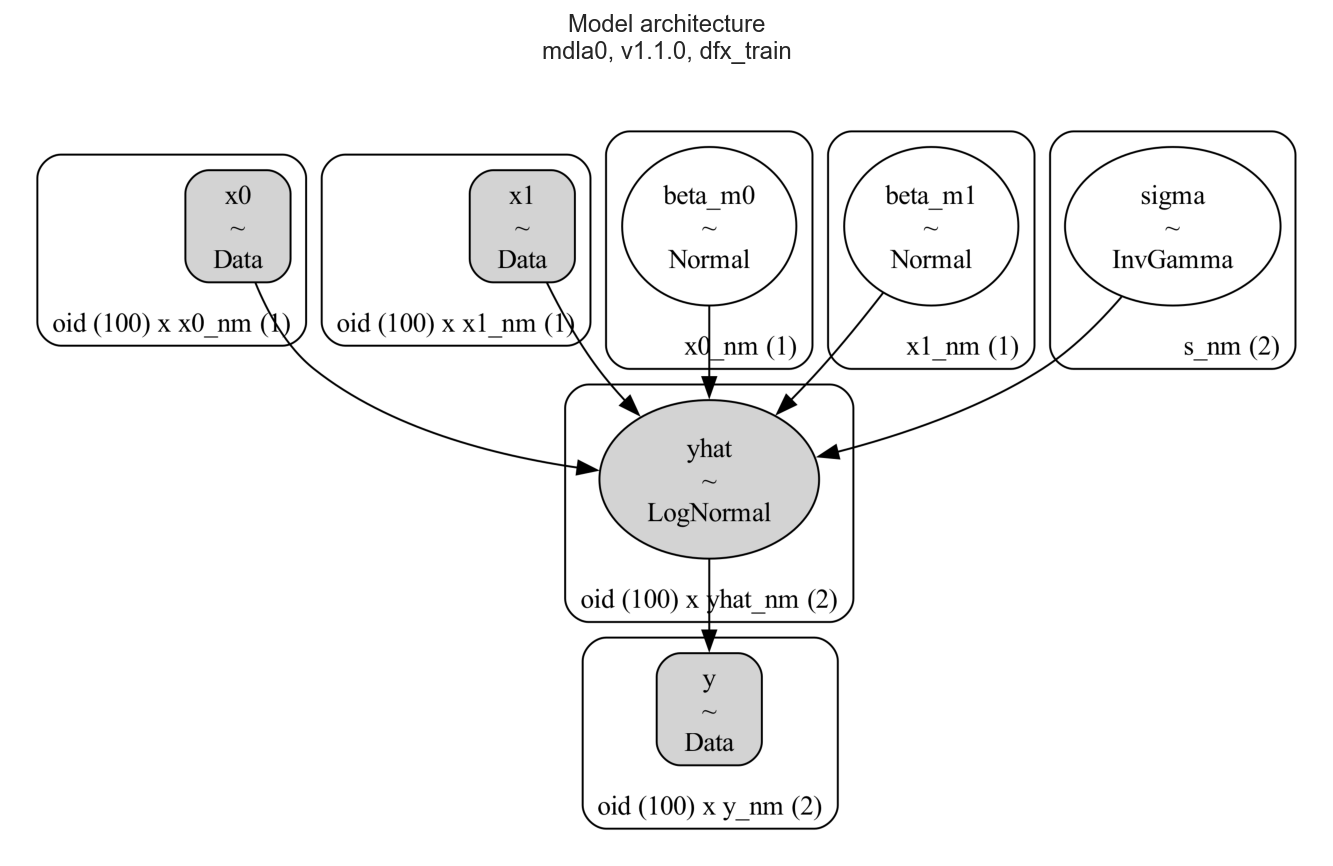

In [10]:
fqn = mdlio.write_graph(mdla0)  # output model graph to prove built
f = figio.read(fqn=fqn, title=f'Model architecture\n{mdla0.mdl_id}', figsize=(12, 6))

## 2.2 Sample Prior Predictive, View Diagnostics

In [11]:
mdla0.sample_prior_predictive(var_names=mdla0.rvs_marg + mdla0.rvs_ppc, replace=True)

#### Evaluate Prior PPC

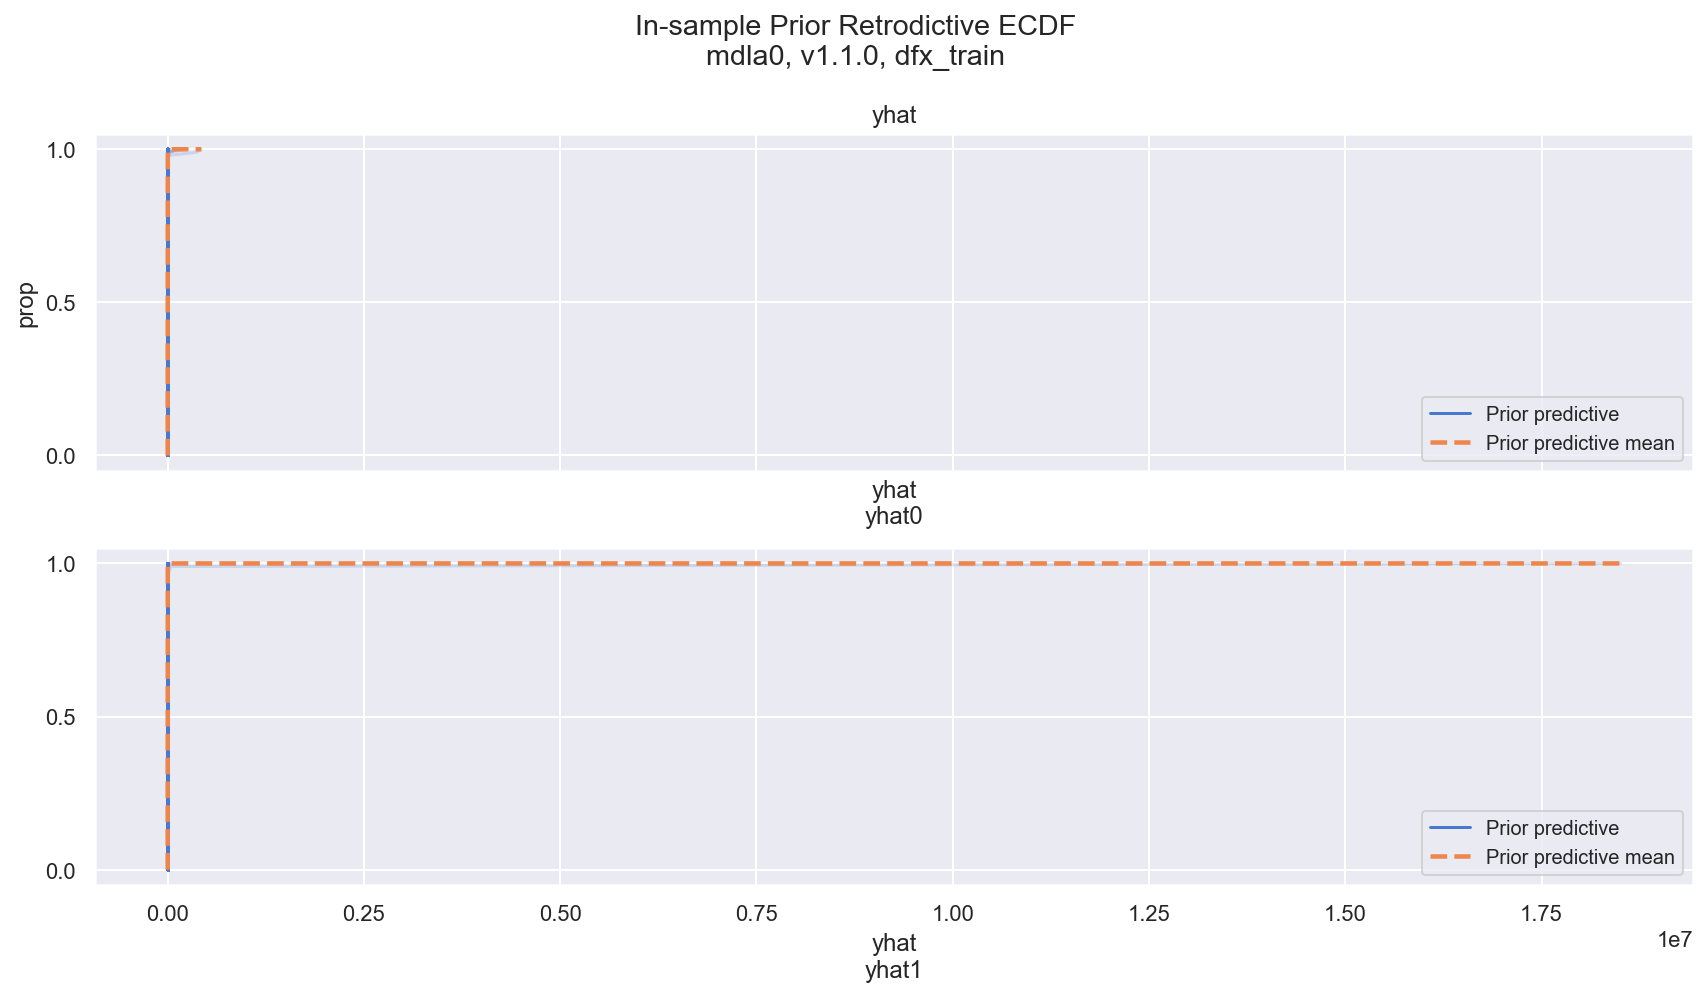

In [12]:
GRP = 'prior'
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=mdla0.rvs_ppc, flatten=['oid'], insamp=True)

**Observe:**

+ Terrible fit as expected, but the range is valid

#### Evaluate priors and hyperpriors on linear model

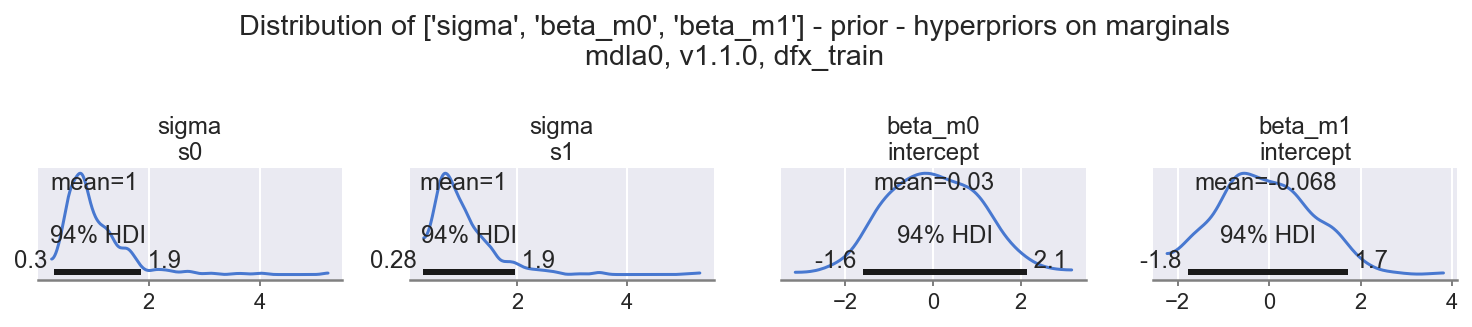

In [13]:
f = mt.facetplot_krushke(mdl=mdla0, group=GRP, txtadd='hyperpriors on marginals',
        rvs=mdla0.rvs_marg, m=4, rvs_hack=1)

**Observe:**

+ Priors contain the reference values, seems reasonable

#### ~~Evaluate priors on copula structure~~

No copula in this naive model

## 2.3 Sample Posterior, View Diagnostics

In [14]:
mdla0.sample(progressbar=True)
mdla0.sample_posterior_predictive(store_ppc=True, ppc_insample=True, var_names=mdla0.rvs_ppc)
mdlio.write_idata(mdl=mdla0)

Output()

Output()

PosixPath('/Users/jon/workspace/oreum/oreum_copula/data/models/idata_mdla0_v110_dfx_train.netcdf')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[s0],0.459,0.033,0.402,0.524,0.001,0.000,3146.0,1535.0,1.00
sigma[s1],1.008,0.073,0.882,1.149,0.001,0.001,2906.0,1692.0,1.00
beta_m0[intercept],0.204,0.044,0.114,0.283,0.001,0.001,3631.0,1582.0,1.00
beta_m1[intercept],1.961,0.103,1.770,2.158,0.002,0.001,2644.0,1486.0,1.01


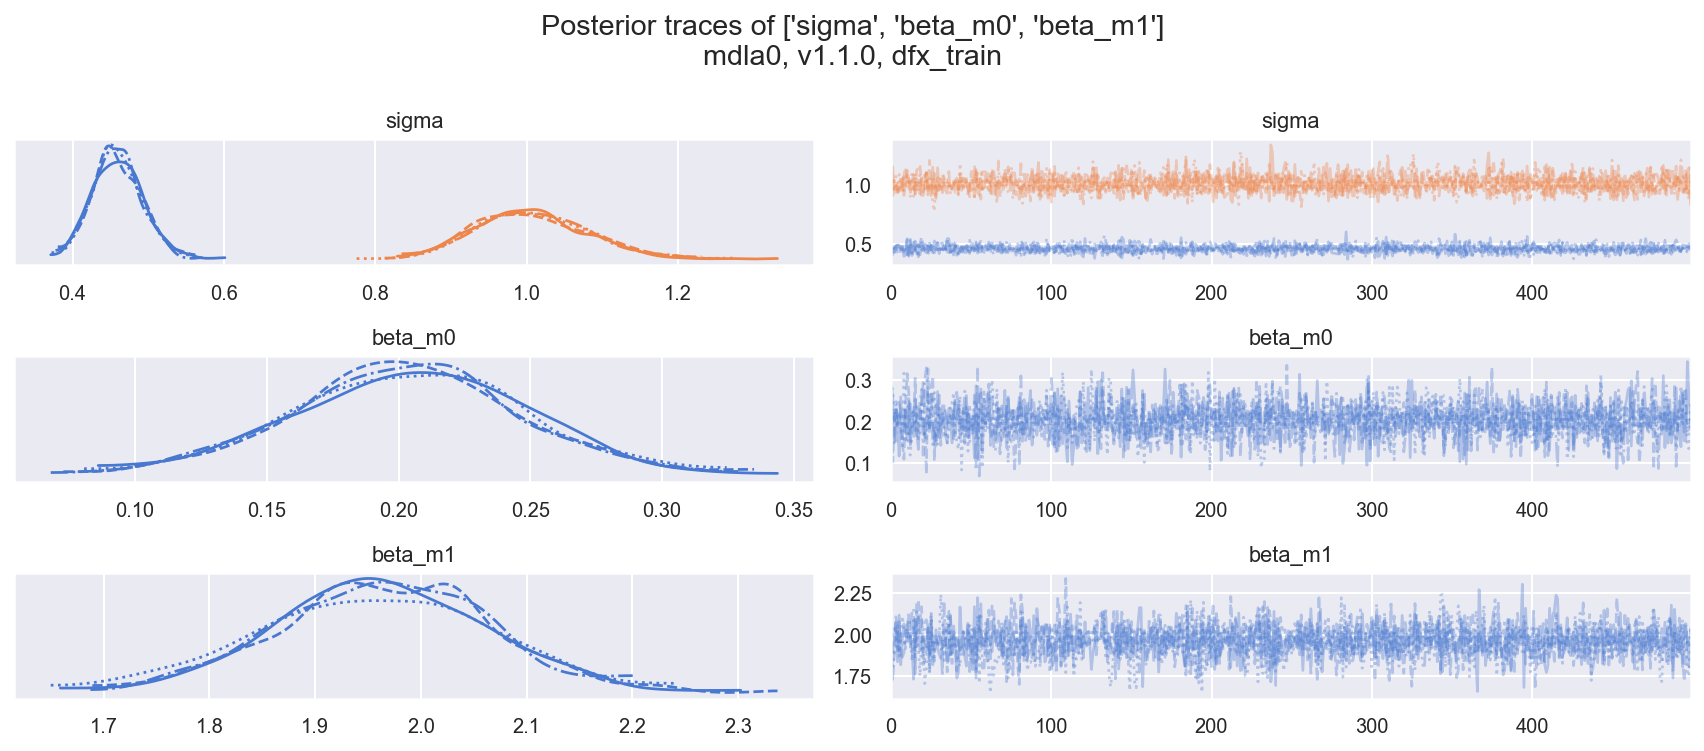

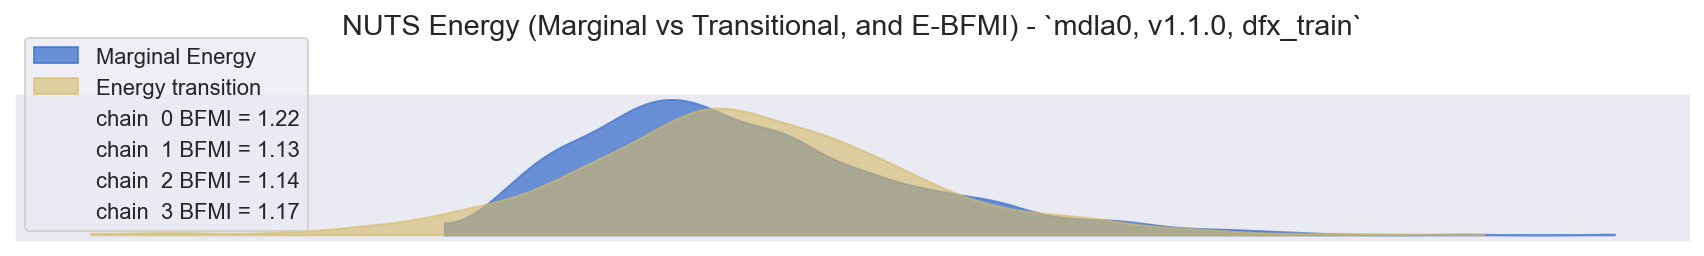

In [15]:
f = mt.plot_trace(mdl=mdla0, rvs=mdla0.rvs_marg, kind='trace')
f = mt.plot_energy(mdl=mdla0)
smry = mt.get_summary(mdl=mdla0, rvs=mdla0.rvs_marg)
smry

**Observe:**

+ Posterior distributions reasonably smooth and central
+ Samples well-mixed and well-behaved: `ess_bulk` is good, `r_hat` is good
+ Marginal energy | energy transition looks okay: `E-BFMI > 0.3` so [apparently reasonable](https://python.arviz.org/en/stable/api/generated/arviz.bfmi.html#arviz.bfmi)

## 2.4 Evaluate Posterior PPC (In-Sample)

### 2.4.1 ECDF Plots: Univariate

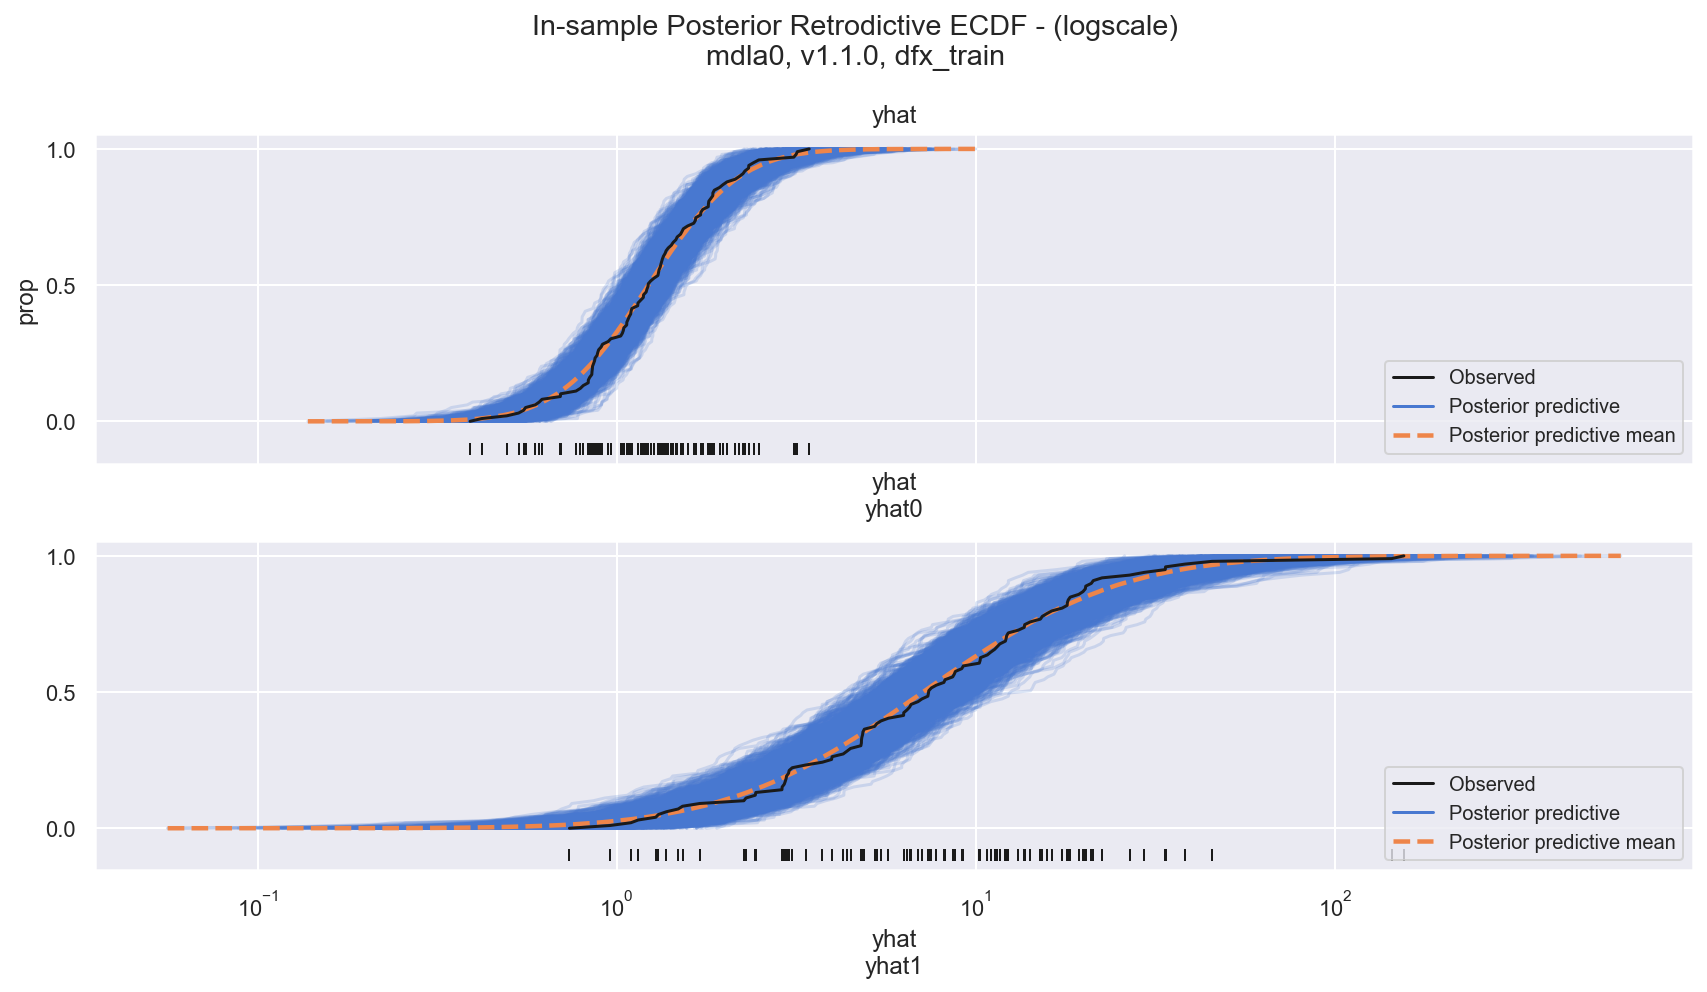

In [16]:
GRP = 'posterior'
f = mt.plot_ppc(mdl=mdla0, group=GRP, var_names=mdla0.rvs_ppc, insamp=True, logx=True,
                flatten=['oid'], observed_rug=True)

**Observe:**

+ Bulk: reasonably good fit for both `m0`, `m1`
+ Tails: reasonable fit for both but heavier than observed

### 2.4.2 Jointplots of PPC marginals

#### Mean

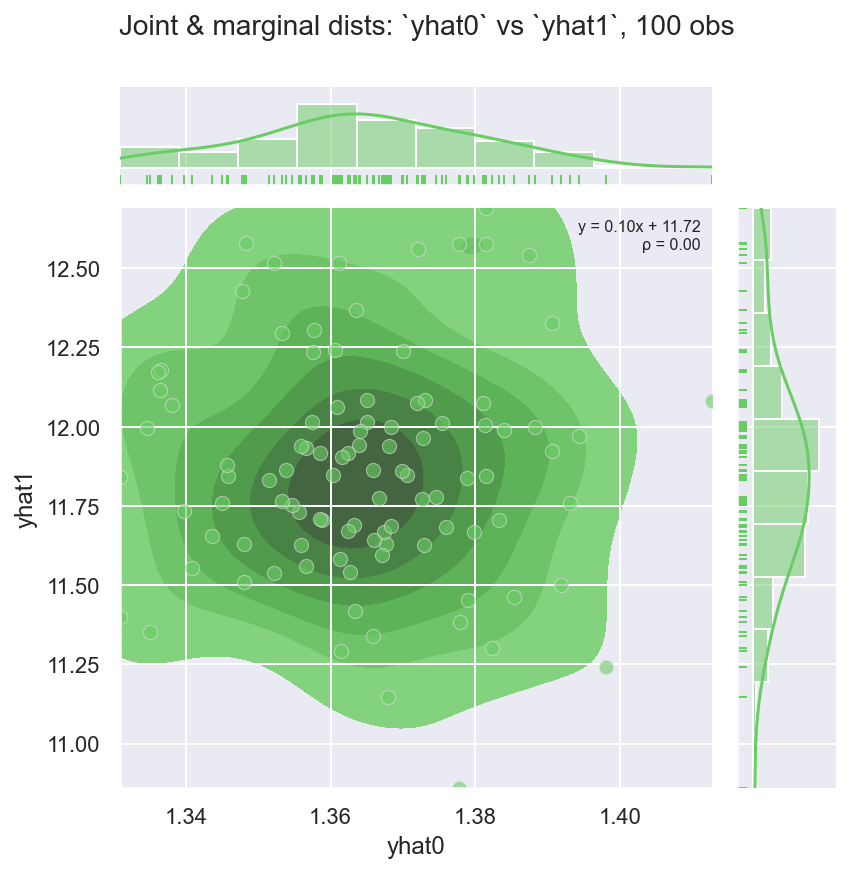

In [24]:
rv = 'yhat'
cols = mdla0.coords[f'{rv}_nm']
x = az.extract(mdla0.idata, group='posterior_predictive', var_names=rv).values
dfp_y = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
f = eda.plot_joint_numeric(data=dfp_y, ft0=cols[0], ft1=cols[1], kind='kde+scatter', 
            colori=2, subtitle='In-Sample Posterior Predictive Marginals (mean)')

**Observe:**

+ Joint distribution looks spherical - does not have the covariance structure of
  the actual data

#### Quantiles

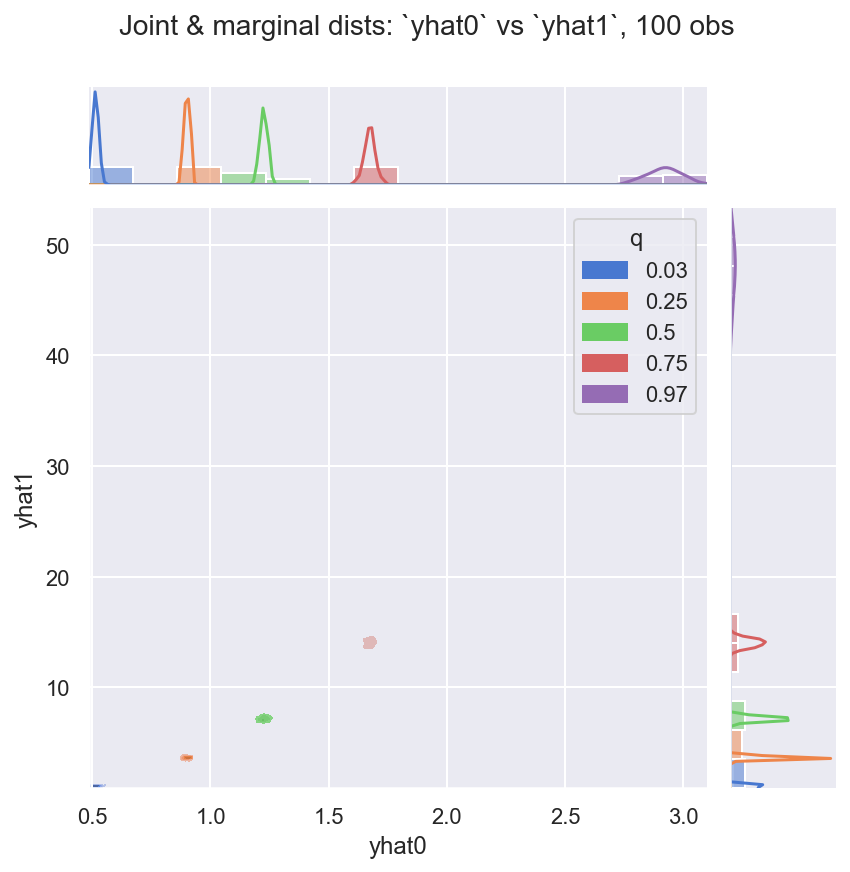

In [26]:
qs = [0.03, 0.25, 0.5, 0.75, 0.97]
dfp_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdla0.n, 2), columns=cols)
dfp_q['q'] = np.repeat([f'{q}'  for q in qs], mdla0.n)
f = eda.plot_joint_numeric(data=dfp_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
            # legendpos='lower right',
            subtitle='In-Sample Posterior Predictive Marginals (quantiles)')

**Observe**

+ The PPC quantile range covers the range of the observed data quite well
+ The extremes quantiles are still very tightly grouped - variance well managed?

## 2.5 Evaluate LOO-PIT (In-Sample)

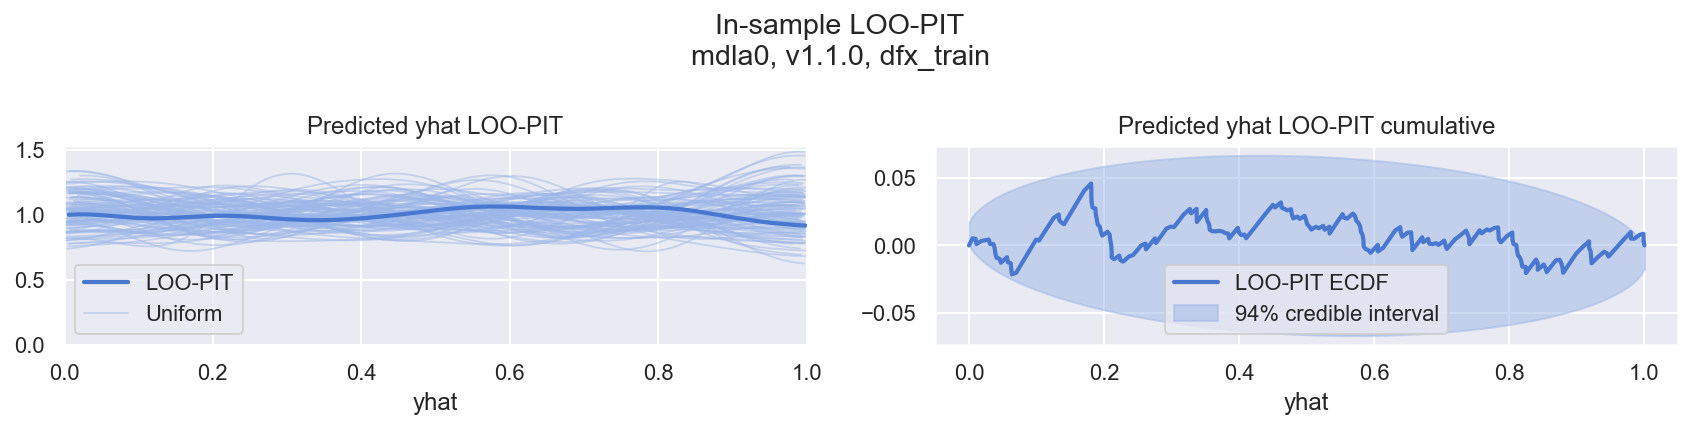

In [17]:
f = mt.plot_loo_pit(mdla0, data_pairs={'yhat': 'yhat'})

**Observe**

+ Seems like a good fit

## 2.6 ~~Compare Log-Likelihood vs other models~~

NOTE:

+ Nothing to compare with yet

## 2.7 Evaluate Fitted Posterior Parameters

NOTE: Because this is a syntehtic dataset, we can evaluate parameter recovery

### 2.7.1 Univariate priors and hyperpriors on linear models

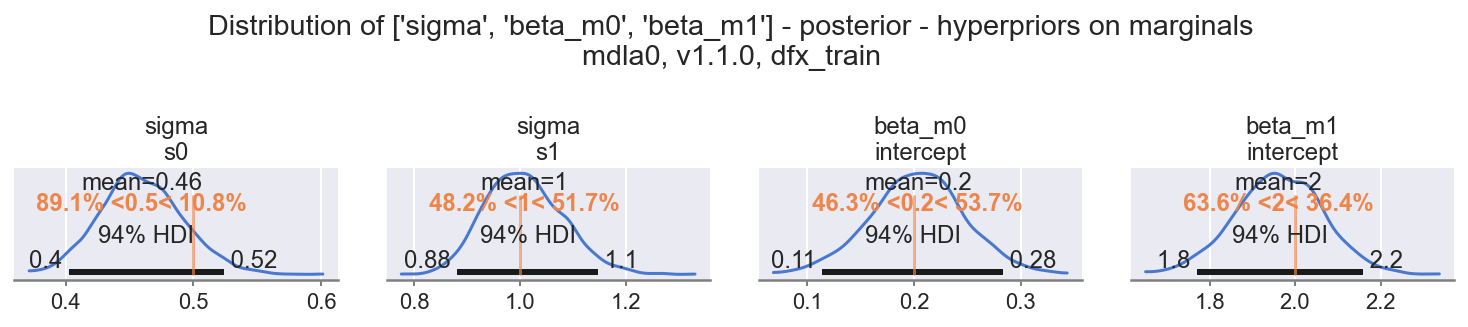

In [20]:
# get ref values from copula builder
refs = [cb.ref_vals['m0_params']['sigma'], cb.ref_vals['m1_params']['sigma'],
        cb.ref_vals['m0_params']['mu'], cb.ref_vals['m1_params']['mu']]
f = mt.facetplot_krushke(mdl=mdla0, group=GRP, txtadd='hyperpriors on marginals',
        rvs=mdla0.rvs_marg, ref_vals=refs, m=4, rvs_hack=1)

**Observe:**

+ `sigma: S0`: $\mathbb{E} \sim 0.46$, $\text{refval} \in \text{HDI}_{94}$. A little lower and narrower than prior
+ `sigma: S1`: $\mathbb{E} \sim 1.0$, $\text{refval} \in \text{HDI}_{94}$. Narrower than prior, but same location
+ `beta_m0: intercept`: $\mathbb{E} \sim 0.2, 0 \notin \text{HDI}_{94}$, $\text{refval} \in \text{HDI}_{94}$. Slightly positive, substantial effect
+ `beta_m1: intercept`: $\mathbb{E} \sim 2.0, 0 \notin \text{HDI}_{94}$, $\text{refval} \in \text{HDI}_{94}$. More positive, substantial effect
+ Parameter recovery looks good for all.

### 2.7.2 Bivariate hyperpriors - looking for correlations

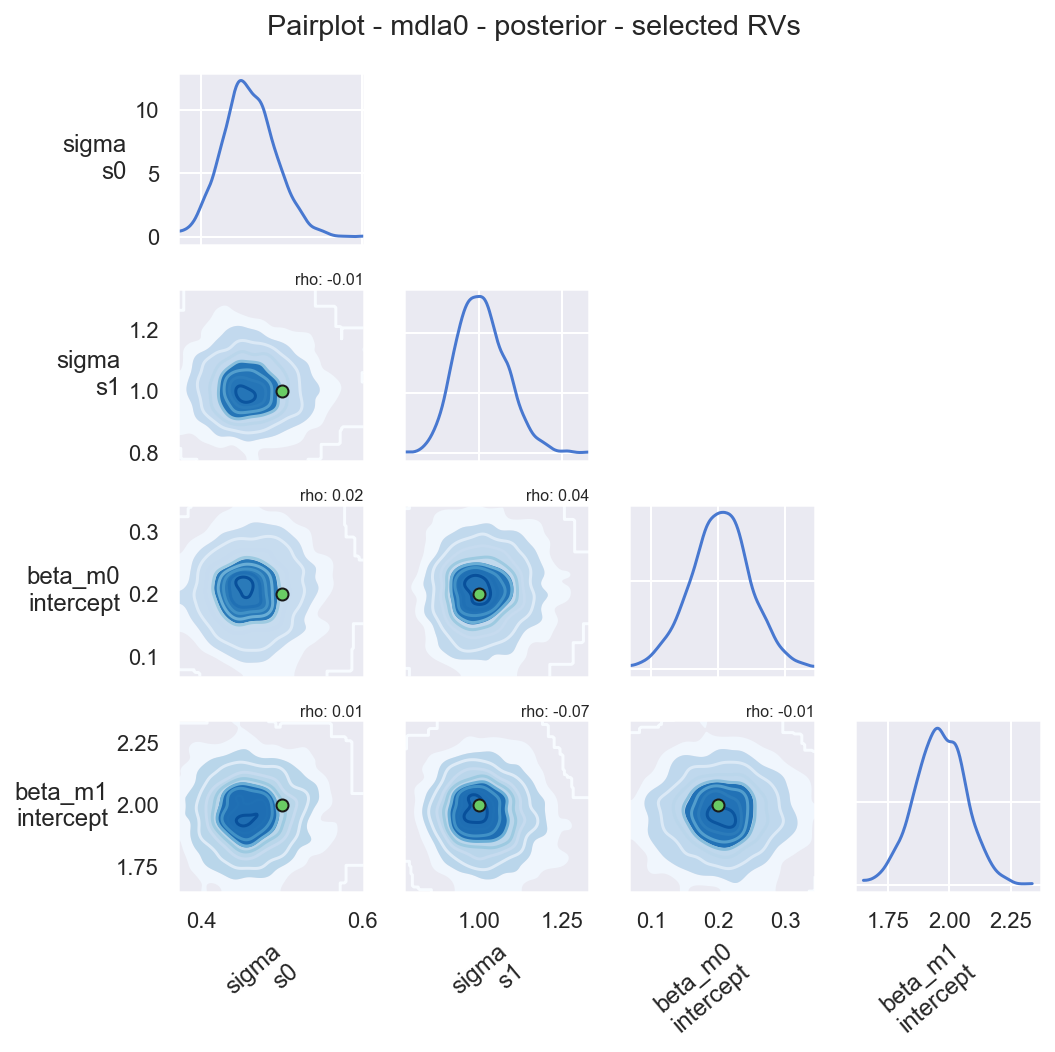

In [ ]:
refsd = {'sigma\ns0': cb.ref_vals['m0_params']['sigma'], 
        'sigma\ns1' :cb.ref_vals['m1_params']['sigma'],
        'beta_m0\nintercept': cb.ref_vals['m0_params']['mu'], 
        'beta_m1\nintercept': cb.ref_vals['m1_params']['mu']}
f = mt.pairplot_corr(mdl=mdla0, rvs=mdla0.rvs_marg, ref_vals=refsd)

**Observe:**

+ Another view of the parameter recovery, which seems good for all.
+ Note lack of correlation between `beta_m0` and `beta_m1` because they're not
  correlated in the model

### 2.7.3 ~~Copula Structure~~

In [ ]:
# assert False, "WIP"

---

---

# 5. Predict Out-of-Sample (Holdout Set)

## 5.1 Sample PPC holdout

In [ ]:
# # replace obs with dfx_pholdout and build
# mdl.replace_obs({'obs_m0': dfx_m0_holdout, 'obs_m1':dfx_m1_holdout})
# mdl.build()

In [ ]:
# fqn = trainer.mdlio.write_graph(mdl, txtadd='holdout')  # output model graph to prove rebuilt
# f = eda.display_image_file(fqn, 
#     title=f'Rebuilt model architecture for holdout: {mdl.name} {mdl.version}', figsize=(12, 6))

In [ ]:
# idata_holdout = mdl.sample_posterior_predictive(store_ppc=False, 
#         ppc_insample=True,  # hack to ensure output is named posterior_predictive so we can do EDCF
#         var_names=mdl.rvs_ppc)

# GROUP = 'posterior_predictive'  # predictions

# idata_holdout

## 5.2 Plot holdouts

Calling back to **1.2.6 Compare the Impact on Joint Distribution** we might consider the PPC Joint Distribution here too. We will keep with the theme that this might represent a Expected Loss Cost $E_{loss}$

NOTE:

+ Within each marginal, the samples for the posterior parameters of a submodel 
  are coherent across the joint posterior parameter space
+ This means for example, that within parameters `yhat0` etc, each of 
  samples `0, 1, 2, 3 ... j` gives us the full state of the model at that point 
  in the Markov chain
+ So, we use all parameter values at each sample `0, 1, 2, 3 ... j`, to get 
  `j` estimates of the posterior parameter values, and thus the predictions
+ We usually set `j = 2000`, so we have $2000$ predictions for each observation

In [ ]:
# yhat = az.extract(idata_holdout, group=GROUP, var_names=mdl.rvs_ppc).values
# yhat_eloss = np.product(yhat, axis=1)
# yhat_eloss.shape

### 5.2.1 Plot holdout Full Set Distribution

In [ ]:
# df_yhat_eloss = pd.DataFrame(yhat_eloss, index=dfx_m0_holdout.index)
# dfm_yhat_eloss = df_yhat_eloss.reset_index().melt(
#                         id_vars='index', value_name='yhat', var_name='sample')
# eda.display_ht(df_yhat_eloss)

In [ ]:
# f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat')

In [ ]:
# f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat', kind='exceedance')

**Observe:**

+ Quite a long tail, high mean, doesn't seem unreasonable

### 5.2.2 Plot holdout Individual Observations

In [ ]:
# mn_pt_kws=dict(markerfacecolor='w', markeredgecolor='#333333', marker='d', markersize=8)
# box_kws=dict(kind='box', sym='', orient='h', showmeans=True, whis=(3, 97), meanprops=mn_pt_kws)
# nobs = len(df_yhat_eloss)
# gd = sns.catplot(x='yhat', y='index', data=dfm_yhat_eloss, **box_kws, height=4, aspect=2)
# _ = gd.fig.suptitle(f'Individual Distribution of yhat Estimate for {nobs} Observations')
# _ = gd.fig.tight_layout()

#### 5.2.3 Mean Joint Distribution

In [ ]:
# rv = 'yhat'
# cols = mdl.coords[f'{rv}_nm']
# x = az.extract(idata_holdout, group=GROUP, var_names=rv).values
# dfp_y = pd.DataFrame(np.nanmean(x, axis=2), columns=cols)
# f = eda.plot_joint_numeric(data=dfp_y, ft0=cols[0], ft1=cols[1], kind='kde+scatter', colori=2, 
#             subtitle='holdout Out-of-Sample Posterior Predictive Marginals (mean)')

**Observe:**

+ Quite broad variance
+ But marginals and joint look reasonably close to holdout actual values

#### 5.2.4 Quantile Joint Distribution

In [ ]:
# qs = [0.03, 0.25, 0.5, 0.75, 0.97]
# dfp_q = pd.DataFrame(np.quantile(x, qs, axis=2).reshape(len(qs)*mdl.n, 2), columns=cols)
# dfp_q['q'] = np.repeat([f'{q}'  for q in qs], mdl.n)
# f = eda.plot_joint_numeric(data=dfp_q, ft0=cols[0], ft1=cols[1], hue='q', kind='kde',
#             legendpos='lower right',
#             subtitle='holdout Out-of-Sample Posterior Predictive Marginals (quantiles)')

**Observe**

+ Very interesting! The PPC quantile range looks reasonable

**In the real world, we have to stop here, because in a holdout scenario we dont have `y`**

---

# 6. Evaluate Predictions (Holdout Set)

**IMPORTANT NOTE** 

Strictly speaking, in a **holdout** dataset / scenario we dont have `y`, but in
this worked example Notebook we do have `y`, so we can treat this more like a 
**Holdout** dataset / scenario, and add several evaluations including:

+ Plot Summarised Predictions with overplotted Actual
+ Plot PPC ECDF
+ Plot Coverage / Calibration
+ Plot RMSE and R^2


## 6.1 Evaluate holdout Joint Distribution ($E_{loss}$)

### 6.1.1 Plot Summarised Predictions with overplotted Actual

In [ ]:
# y_m0 = dfx_m0_holdout['m0'].values
# y_m1 = dfx_m1_holdout['m1'].values
# y_eloss = y_m0 * y_m1
# df_y_eloss = pd.DataFrame({'y': y_eloss}, index=dfx_m0_holdout.index).reset_index()

In [ ]:
# f = eda.plot_estimate(dfm_yhat_eloss, len(df_yhat_eloss), yhat='yhat', 
#                     arroverplot=df_y_eloss['y'], txtadd='with overplotted bootstrapped Actual')
# figio.write(f, fn=f'100_6.1.1_holdout_prediction_{mdl.name}')

**Observe:**

+ Now we can see the prediction from this naive model is much too high and the 
  variance is too large
+ The overplotted actual sample mean is 9.3, and the estimated mean is 16.2,
  a $16.2/9.3 \sim +74\%$ overestimate!


### 6.1.2 Plot PPC EDCF

In [ ]:
# # hacky correct for sample_posterior_predictive not creating observed data 
# # (because model observed_RVs is empty)
# if 'observed_data' not in idata_holdout.groups():
#     idata_holdout.add_groups(observed_data=deepcopy(mdl.idata.observed_data))

# idata_holdout

In [ ]:
# _ = mt.plot_ppc(mdl, idata=idata_holdout, group='posterior', insamp=False,
#                 data_pairs={'yhat': 'yhat'}, flatten=['oid'], observed_rug=True)

**Observe:**

+ Bulk: reasonably good fits, but high variance
+ Tails: reasonable fit, rather heavier than observed, esp for `yhat1`

### 6.1.3 Plot Coverage

In [ ]:
# df_cov_eloss = mt.calc_ppc_coverage(y_eloss, yhat_eloss.T)
# f = eda.plot_coverage(df_cov_eloss)

**Observe:**

+ Reasonably well-calibrated
+ AUC: quite large

### 6.1.4: Plot RMSE and R^2

In [ ]:
# rmse, rmse_pct = mt.calc_rmse(y_eloss, yhat_eloss.T)
# f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='yhat_eloss')

# r2 = mt.calc_bayesian_r2(y_eloss, yhat_eloss)
# f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE quite high variance
+ R^2 mean seems reasonable, but has high variance

## 6.2 Evaluate Marginal Distributions

**IMPORTANT NOTE** 

Strictly speaking, in a **holdout** dataset / scenario we dont have `y`, but in
this worked example Notebook we do have `y`, so we can treat this more like a 
**Holdout** dataset / scenario, and add several evaluations including:

+ Plot Coverage
+ Plot RMSE and R^2


### 6.2.1 Margin M0

#### 6.2.1.1 Coverage

In [ ]:
# dfcov_m0 = mt.calc_ppc_coverage(y_m0, yhat[:, 0].T)
# f = eda.plot_coverage(dfcov_m0)

**Observe:**

+ Looks pretty well-calibrated

#### 6.2.1.2: RMSE and R^2

In [ ]:
# rmse, rmse_pct = mt.calc_rmse(y_m0, yhat[:, 0].T)
# f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='m0')

# r2 = mt.calc_bayesian_r2(y_m0, yhat[:, 0])
# f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE quite high variance
+ R^2 mean seems reasonable, but has high variance

### 6.2.2 Margin M1

#### 6.2.2.1 Coverage

In [ ]:
# dfcov_m1 = mt.calc_ppc_coverage(y_m1, yhat[:, 1].T)
# f = eda.plot_coverage(dfcov_m1)

**Observe:**

+ Also reasonably well-calibrated

#### 6.2.2.2: RMSE and R^2

In [ ]:
# rmse, rmse_pct = mt.calc_rmse(y_m1, yhat[:, 1].T)
# f = eda.plot_rmse_range(rmse, rmse_pct, yhat_name='m1')

# r2 = mt.calc_bayesian_r2(y_m1, yhat[:, 1])
# f = eda.plot_float_dist(r2, ['r2'], log=False)

**Observe:**

+ RMSE quite high variance
+ R^2 mean seems reasonable, but has high variance

---

---

# Notes

In [ ]:
%load_ext watermark
%watermark -a "jonathan.sedar@oreum.io" -udtmv -iv -p pymc,pytensor

---
**Oreum OÜ &copy; 2024**